In [54]:
# %load_ext autoreload
# %autoreload 2

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from paths import PF_DB_PATH, DATA_DIR
from IPython.display import Markdown as md
from IPython.display import display
import os 

DEBUG= False

In [41]:
def display_list(lst: list, sep=", ") -> str:
    # join list items to return a merged str for display
    return sep.join(lst)

def debug(df):
    # display df if in debug mode
    if DEBUG:
        display(df)

# Raw Data
Dataset was downloaded as separated `.xlsx` files, which are then merged into a single SQLite database. The SQL database consists of 2 tables:

In [42]:
con= sqlite3.connect(PF_DB_PATH)
raw_records= pd.read_sql_query("SELECT * FROM record", con)
raw_property=  pd.read_sql_query("SELECT * FROM property", con)

In [43]:
md(
    f"""
1. records\n
    This table contains {raw_records.shape[0]:,} property sales records, each record contains the following data:
    * `id`: unique identification of the sales record, formed by merging address, postcode and sale date
    * `record_date`: date of sale (from {raw_records.record_date.min()} to {raw_records.record_date.max()})
    * `price`: final sale price
    * `sale_type`: type of sale ({display_list(raw_records.sale_type.unique().tolist())})
    * `prop_id`: id of the property, formed by merging address and postcode
    * `property_type`: type of property ({display_list(raw_records.property_type.unique().tolist())})
    * `bedrooms`: number of bedrooms
    * `bathrooms`: number of bathrooms
    * `carparks`: number of car parks
2. property\n
    This table contains {raw_property.shape[0]:,} properties that have associated sales record(s), each property details consist of the following data:
    * `address`: address with postcode attached, act as unique identification
    * `street`: street name
    * `locality`: suburb name ({raw_property.locality.nunique()} in total)
    * `postcode`: postcode ({raw_property.postcode.nunique()} in total)
    * `land_area`: land area
"""
)


1. records

    This table contains 731,552 property sales records, each record contains the following data:
    * `id`: unique identification of the sales record, formed by merging address, postcode and sale date
    * `record_date`: date of sale (from 2000-01-05 to 2022-01-04)
    * `price`: final sale price
    * `sale_type`: type of sale (Agents Advice - Sale, Normal Sale, Multi-Sale, Part Sale, Unknown)
    * `prop_id`: id of the property, formed by merging address and postcode
    * `property_type`: type of property (Commercial, Unit, Other, House, Vacant Land, Industrial)
    * `bedrooms`: number of bedrooms
    * `bathrooms`: number of bathrooms
    * `carparks`: number of car parks
2. property

    This table contains 455,865 properties that have associated sales record(s), each property details consist of the following data:
    * `address`: address with postcode attached, act as unique identification
    * `street`: street name
    * `locality`: suburb name (844 in total)
    * `postcode`: postcode (312 in total)
    * `land_area`: land area


In [44]:
debug(raw_records.describe(include = 'all'))
debug(raw_property.describe(include='all'))

# Data Cleaning

In [45]:
# raw dataframe
df_raw= (
    pd.merge(raw_records, raw_property, left_on='prop_id', right_on='address', how= 'left')
    .drop(columns=['prop_id'])
)

# filtered dataframe
last_record_date = '2021-12-31'
df_clean= df_raw.query(f'bedrooms<=5 & bathrooms<=5 & carparks <=3')
df_clean= df_clean[df_clean.record_date <= last_record_date]
df_clean['year']= pd.DatetimeIndex(df_clean.record_date).year


In [46]:
md(f'''
There is no missing values in both tables. For records, unusually high number of bedrooms, bathrooms and car parks were found, possible due to the sale of buildings as a whole. For normal household, only properties with maximum 5 bedrooms/bathrooms and 3 car parks were considered.

Also, to aid yearly aggregation, a `year` column was generated from `record_date`. It should be noted that only sales records on or before {last_record_date} were considered to ensure accuracy of annual statistics.

Consequently, a combined dataset was then formed by merging the two tables with left join on `records`. The final dataset for analysis consists of {df_clean.shape[0]:,} records ({df_clean.shape[0]/df_raw.shape[0]:.0%} of available records).
''')


There is no missing values in both tables. For records, unusually high number of bedrooms, bathrooms and car parks were found, possible due to the sale of buildings as a whole. For normal household, only properties with maximum 5 bedrooms/bathrooms and 3 car parks were considered.

Also, to aid yearly aggregation, a `year` column was generated from `record_date`. It should be noted that only sales records on or before 2021-12-31 were considered to ensure accuracy of annual statistics.

Consequently, a combined dataset was then formed by merging the two tables with left join on `records`. The final dataset for analysis consists of 697,935 records (95% of available records).


In [47]:
debug(raw_records.isna().sum())
debug(raw_property.isna().sum())
debug(df_clean.describe(include='all').style.format(dict(price= "{:,.0f}")))


Further analysis suggested that most records were Normal Sales of either House or Unit properties. For simplicity and sake of interest, only these records were considered.

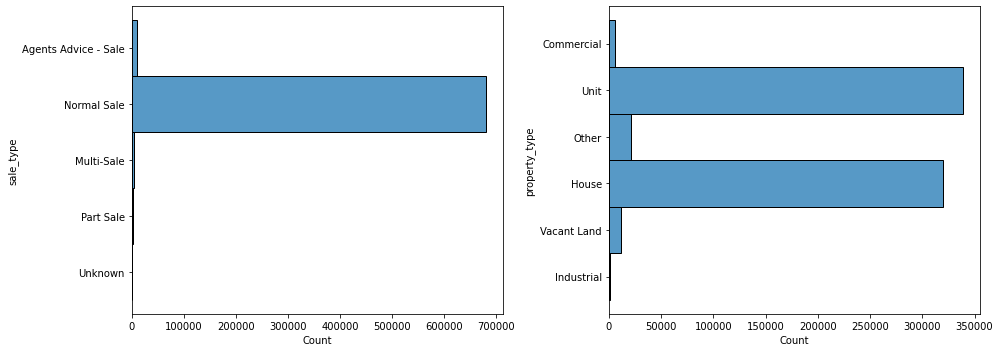

In [48]:
nrow, ncol = 1,2
fig, axs= plt.subplots(nrow,ncol, figsize=(ncol*7, nrow*5))
axs= iter(axs.ravel())
sns.histplot(data=df_clean, y='sale_type', ax= next(axs))
sns.histplot(data=df_clean, y='property_type', ax= next(axs))
fig.tight_layout()

For sale prices, a small portion of properties were sold in high value. To focus on properties of affordable range, only records with sale price below 3,000,000 were considered.

In [49]:
# filter out selected sale_type and property_type
df_sel = df_clean[
    (df_clean.sale_type == "Normal Sale")
    & (df_clean.property_type.isin(["Unit", "House"]))
]

df = df_sel.query('price <= 3e6')

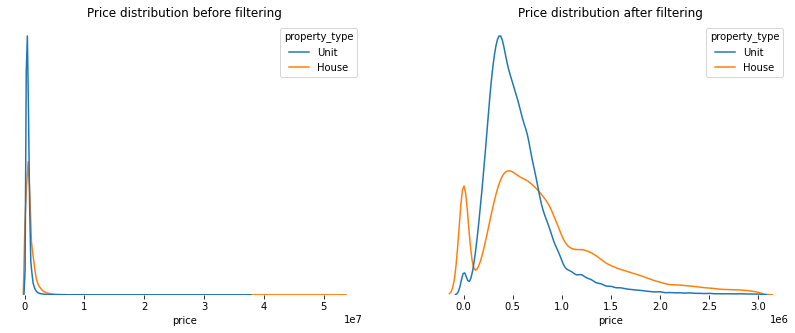

In [50]:
nrow, ncol = 1,2
fig, axs= plt.subplots(nrow,ncol, figsize=(ncol*7, nrow*5))
axs= iter(axs.ravel())

def plot_dist(df, ax, title):
    sns.kdeplot(data= df, x= 'price', hue='property_type', ax=ax)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(title)

plot_dist(df_sel, next(axs), 'Price distribution before filtering')
plot_dist(df, next(axs), 'Price distribution after filtering')



In [51]:
debug(df.sale_type.unique())
debug(df.property_type.unique())

In [52]:
md(f'''
The remaining dataset therefore contains {df.shape[0]:,} records ({df.shape[0]/df_raw.shape[0]:.0%} of the raw data)
''')


The remaining dataset therefore contains 632,570 records (86% of the raw data)


In [53]:
# export as csv
df.to_csv(os.path.join(DATA_DIR, 'dataset.csv'), index=False)